# Penn Athletics

## Library & Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import xlrd

Download data from [Box](https://upenn.box.com/s/3h1t4aud4f2kubuhh10mtihzshk5y4cm).

(I created another Dropbox folder with the same files to make them easier to download. If you want to download and upload all the data, it would be fine too, I just prefer this way to avoid all the dragging.)

In [ ]:
!wget --max-redirect=3 -O gps_data.zip https://www.dropbox.com/sh/vodmk80chsewuuu/AACpb8cwAM_Kqa_Zum3bTGjga?dl=0
!unzip -q gps_data.zip

--2023-02-23 10:36:37--  https://www.dropbox.com/sh/vodmk80chsewuuu/AACpb8cwAM_Kqa_Zum3bTGjga?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/vodmk80chsewuuu/AACpb8cwAM_Kqa_Zum3bTGjga [following]
--2023-02-23 10:36:37--  https://www.dropbox.com/sh/raw/vodmk80chsewuuu/AACpb8cwAM_Kqa_Zum3bTGjga
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc10d61de49d04a3811673540649.dl.dropboxusercontent.com/zip_download_get/BabyHAYIfViuqcLC7MVGpQmh81U3DSKCUmSLEb1aGeENaPoKLCZGXpgpiIX1qkCunebWH7mFWhd24XPuZewaJWy6Li5UOEoLire9yEXsA3ZxgQ# [following]
--2023-02-23 10:36:37--  https://uc10d61de49d04a3811673540649.dl.dropboxusercontent.com/zip_download_get/BabyHAYIfViuqcLC7MVGpQmh81U3DSKCUmSLEb1aGeENaPoKLCZGXpgpiIX1qkCunebWH7mFWhd24XPuZewaJWy6Li5U

## Data Dictionary

Notes from Russ.

- The last letter-number combination refers to a specific athlete.
- The time on the GPS data starts whenever the playertek device is started. Players have a ~30 min warm up before the game.  

In [ ]:
df_list = []

In [ ]:
for folder in ['Brown', 'Harvard', 'Northwestern', 'Yale']:
  file_list = [file for file in os.listdir(folder) if '.csv' in file]
  for file in file_list:
    df = pd.read_csv(folder + '/' + file)

    athlete = file.split('_')[1][:-4]
    game = file.split('-')[1]
    dt = file.split('-')[2].split('_')[0]

    df['athlete'] = athlete
    df['game'] = game
    df['date'] = dt

    df_list.append(df)

In [ ]:
df = pd.concat(df_list, ignore_index=True)

In [ ]:
df['Timestamp'] = df['Excel Timestamp'].apply(xlrd.xldate_as_datetime, args=(0,))

In [ ]:
df

,Excel Timestamp,Speed,Latitude,Longitude,Accel X,Accel Y,Accel Z,Heart Rate,athlete,game,date,Timestamp
0,44849.480575,0.137779,39.946097,-75.190941,0.890315,0.003501,0.376896,119,F16,brown,1015,2022-10-15 11:32:01.700
1,44849.480576,0.013333,39.946097,-75.190941,0.831972,-0.136523,0.411902,119,F16,brown,1015,2022-10-15 11:32:01.800
2,44849.480578,0.066667,39.946097,-75.190941,0.831972,-0.148191,0.365228,119,F16,brown,1015,2022-10-15 11:32:01.900
3,44849.480579,0.071112,39.946097,-75.190941,0.913652,-0.019837,0.376896,119,F16,brown,1015,2022-10-15 11:32:02.000
4,44849.480580,0.200002,39.946097,-75.190942,0.913652,0.073512,0.353559,119,F16,brown,1015,2022-10-15 11:32:02.100
...,...,...,...,...,...,...,...,...,...,...,...,...
4160467,44856.581995,0.737784,41.312170,-72.967048,0.785298,0.225204,-0.241540,153,F16,yale,1022,2022-10-22 13:58:04.400
4160468,44856.581997,0.000000,41.312170,-72.967048,0.785298,0.085181,-0.404901,153,F16,yale,1022,2022-10-22 13:58:04.500
4160469,44856.581998,0.000000,41.312170,-72.967048,0.808635,-0.078180,-0.346558,153,F16,yale,1022,2022-10-22 13:58:04.600
4160470,44856.581999,0.000000,41.312170,-72.967048,0.971995,-0.066511,-0.404901,153,F16,yale,1022,2022-10-22 13:58:04.700


What to do with data that has Heart Rate = 0?

Visualization ideas:

By athlete:
- Distance traveled (avg heart rate, speed)
- Average speed vs. heart rate
- Caclulate force using player stats, accel, speed
- Pace_0 (athlete vs. standard deviation of speed)
- Pace_1 (time vs. speed deviation from mean)
- Movement (athlete vs. time spent static)
- Acceleration in the direction of movement?


## Data Visualizations

### Fitness

In [ ]:
# total distance for each athlete per game
import geopy.distance

players = df["athlete"].unique()
games = df["game"].unique()
total_dist = []

for player in players:
  df_p = df[df["athlete"] == player][[" Latitude", " Longitude", "game"]].reset_index(drop = True)

  for i in range(1, len(df_p) - 1):
    c0 = (df_p.at[i-1, " Latitude"], df_p.at[i-1, " Longitude"])
    c1 = (df_p.at[i, " Latitude"], df_p.at[i, " Longitude"])
    df_p.at[i, "dist_change"] = geopy.distance.geodesic(c0, c1).feet

  df_p.dropna(inplace = True)
  dist_pgame = []

  for game in games:
    dist_pgame.append(sum(df_p[df_p["game"] == game]["dist_change"]))

  total_dist.append(dist_pgame)

Fit distance and potentially model when players start to get tired

In [ ]:
player_dist = pd.DataFrame(total_dist, columns = games).set_index(players).reset_index().rename(columns = {"index" : "athlete"})
player_dist = player_dist.loc[:, player_dist.columns != "yale"]

pdist_long = pd.melt(player_dist, id_vars = ["athlete"], value_vars = ["brown", "harvard", "northwestern"],\
                     var_name = "game", value_name = "dist_ft").sort_values("athlete").reset_index(drop = True)

fitness = df.groupby(["athlete", "game"], as_index = False).agg(med_speed = (" Speed", "median"),\
                                                      std_speed = (" Speed", "std"),\
                                                      avg_speed = (" Speed", "mean"),\
                                                      med_hr = (" Heart Rate", "median"),\
                                                      avg_hr = (" Heart Rate", "mean"))
fitness = fitness[fitness["game"] != "yale"]

In [ ]:
player_fitness = pdist_long.merge(fitness, how = "left", on = ["athlete", "game"]).dropna().reset_index(drop = True)
# player_fitness = player_fitness[(player_fitness["dist_ft"] != float(0)) & (player_fitness[" Speed"] != float(0)) & (player_fitness[" Heart Rate"] != float(0))].reset_index(drop = True)
player_fitness.head()

,athlete,game,dist_ft,med_speed,std_speed,avg_speed,med_hr,avg_hr
0,A15,harvard,8432.015438,0.035556,0.712241,0.297847,119.0,121.843705
1,A15,brown,13669.339102,0.044445,0.947582,0.475723,129.0,135.090900
2,A15,northwestern,9875.223813,0.035556,0.596370,0.269634,122.0,124.394683
3,B5,harvard,26809.996054,0.951119,1.117040,1.129723,0.0,0.000000
4,B5,northwestern,28253.871188,0.746673,0.999785,0.982876,0.0,0.000000


In [ ]:
# seaborn figure size config
sns.set(rc = {'figure.figsize': (12, 9)})

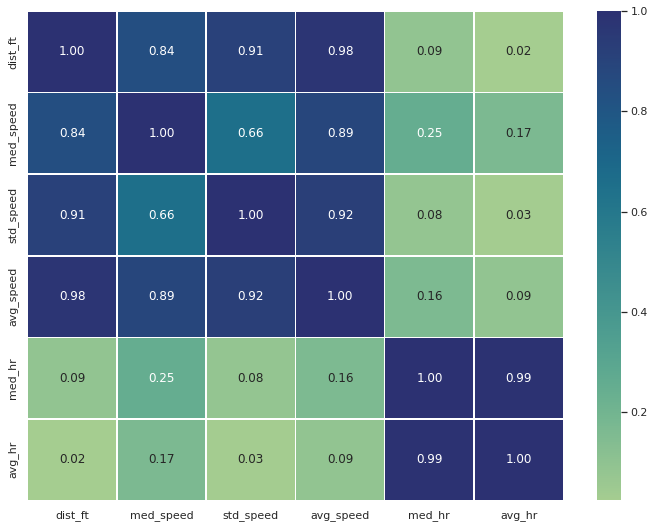

In [ ]:
sns.heatmap(data = player_fitness.corr(), annot = True, fmt = ".2f", linewidth = .5, cmap = "crest")

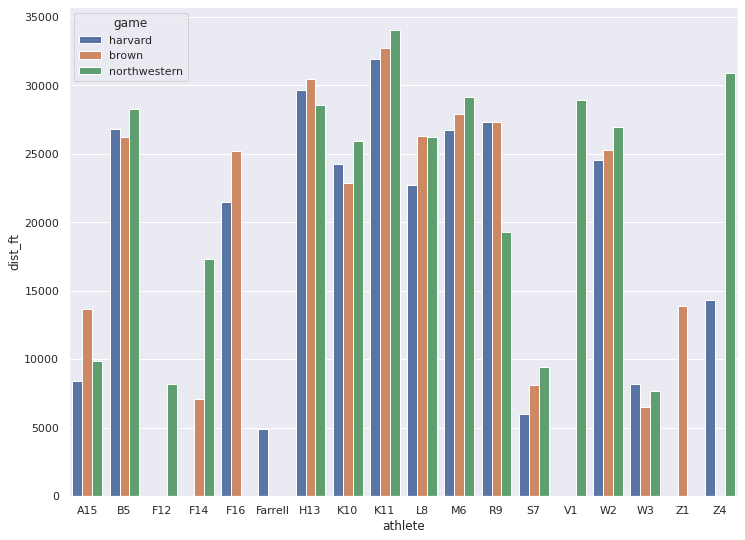

In [ ]:
sns.barplot(data = player_fitness, x = "athlete", y = "dist_ft", hue = "game")

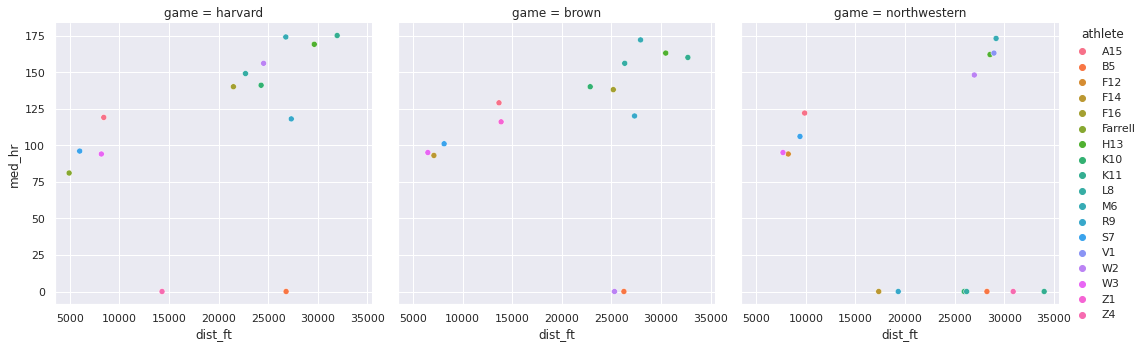

In [ ]:
# need to filter heart rate == 0 in original df
sns.relplot(
    data = player_fitness, x = "dist_ft", y = "med_hr",
    col = "game", hue = "athlete", kind = "scatter"
)

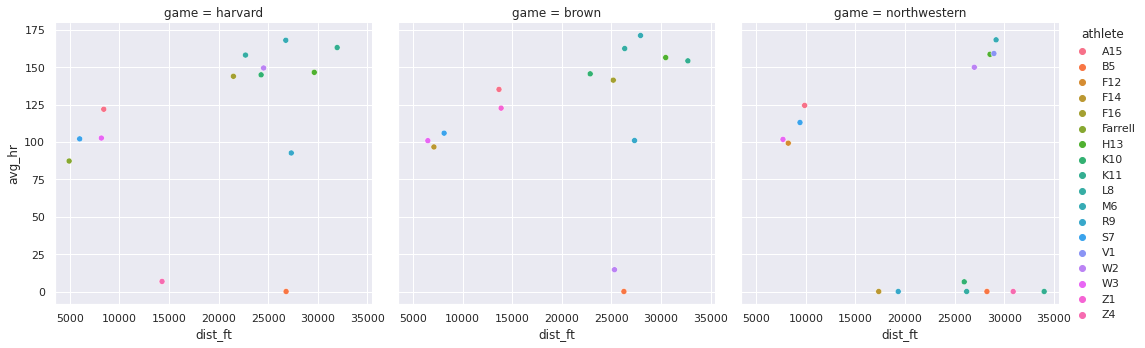

In [ ]:
# need to filter heart rate == 0 in original df
sns.relplot(
    data = player_fitness, x = "dist_ft", y = "avg_hr",
    col = "game", hue = "athlete", kind = "scatter"
)

Good fitness athletes at (27000, 100)

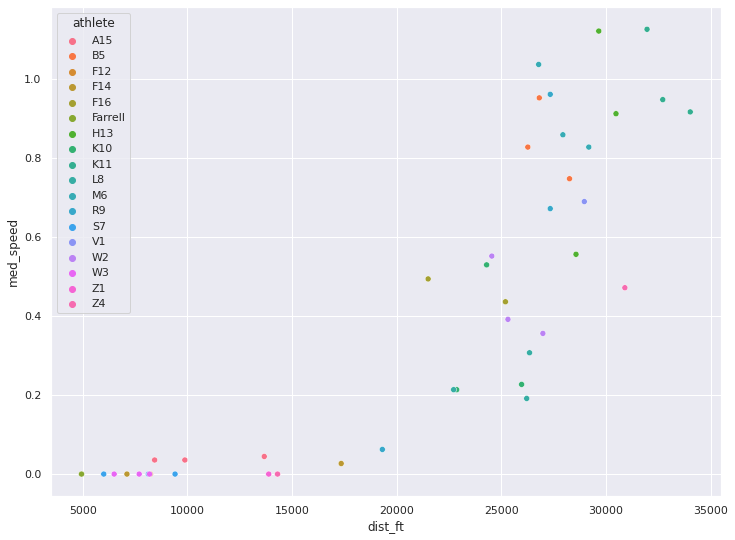

In [ ]:
sns.scatterplot(data = player_fitness, x = "dist_ft", y = "med_speed", hue = "athlete")

Positional implications for athletes that cover small distance but fast median speed?

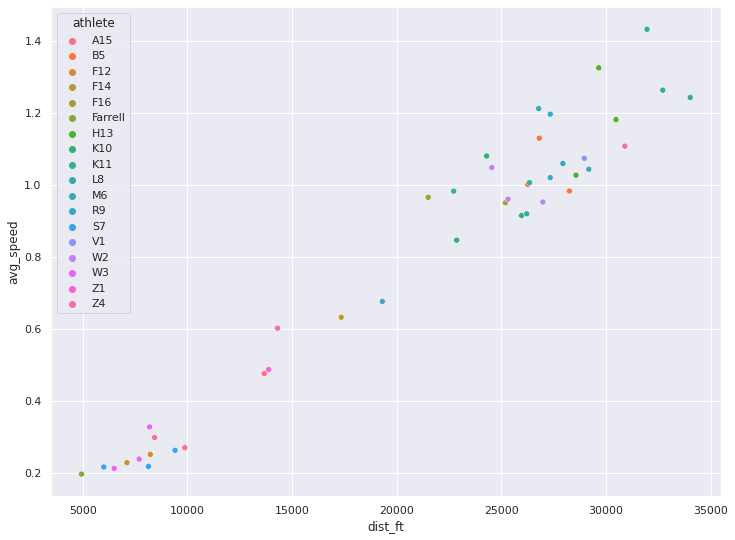

In [ ]:
sns.scatterplot(data = player_fitness, x = "dist_ft", y = "avg_speed", hue = "athlete")

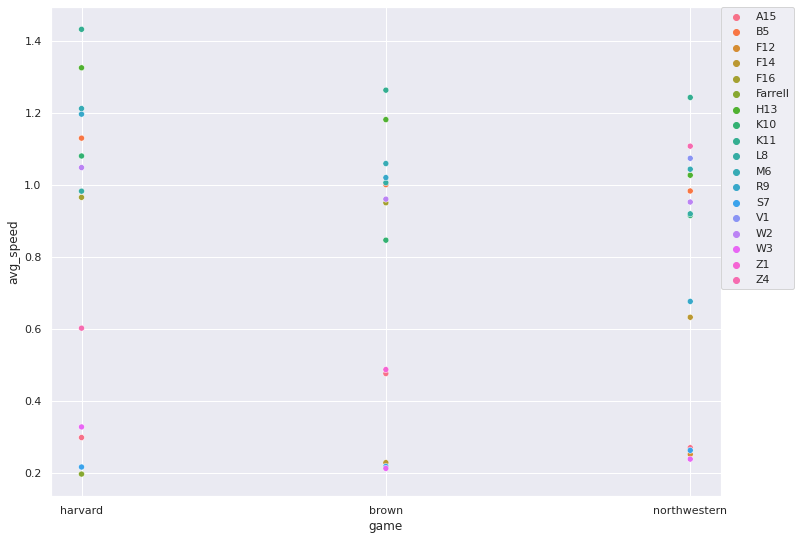

In [ ]:
sns.scatterplot(data = player_fitness, x = "game", y = "avg_speed", hue = "athlete")
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

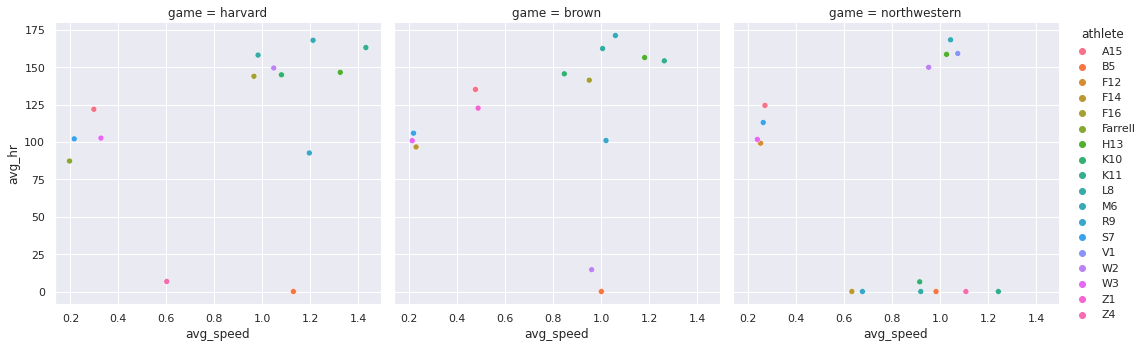

In [ ]:
# measure fitness through speed vs. hr
sns.relplot(
    data = player_fitness, x = "avg_speed", y = "avg_hr",
    col = "game", hue = "athlete", kind = "scatter"
)

### Pace

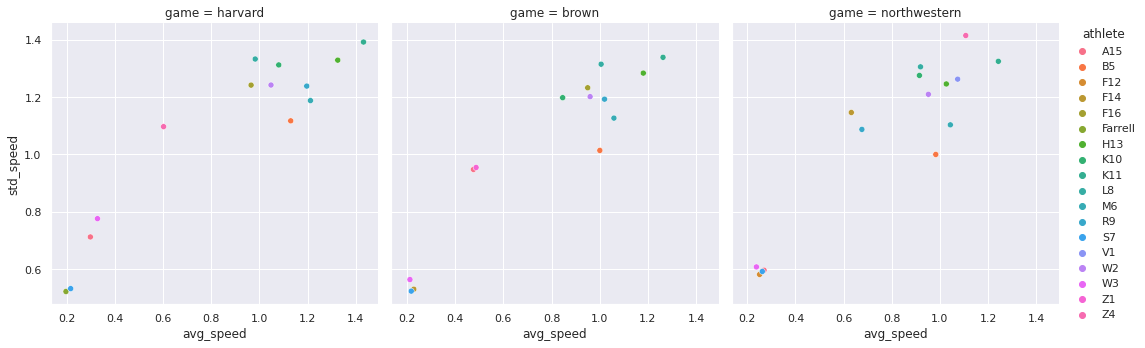

In [ ]:
sns.relplot(
    data = player_fitness, x = "avg_speed", y = "std_speed",
    col = "game", hue = "athlete", kind = "scatter"
)

Orange and turquoise can run relatively quickly, steadily throughout the game.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_t = df.copy()
df_t["Timestamp_s"] = df_t["Timestamp"].apply(lambda x: x.replace(microsecond = 000))
df_t = df_t.groupby(["Timestamp_s", "athlete", "game"], as_index = False).agg(Speed = (" Speed", "mean"), HR  = (" Heart Rate", "mean"))
df_t.head()

,Timestamp_s,athlete,game,Speed,HR
0,2022-09-16 14:25:34,S7,northwestern,0.917468,105.714286
1,2022-09-16 14:25:35,S7,northwestern,0.636548,106.000000
2,2022-09-16 14:25:36,S7,northwestern,0.109631,107.000000
3,2022-09-16 14:25:36,V1,northwestern,0.215557,108.000000
4,2022-09-16 14:25:37,S7,northwestern,0.215002,109.125000


In [ ]:
players = df["athlete"].unique()
games = df["game"].unique()

for player in players:
  df_p = df_t[df_t["athlete"] == player].reset_index(drop = True)

  for game in games:
    df_p = df_p[df_p["game"] == game]

    plt.scatter(df_p["Timestamp_s"], df_p["Speed"])
    plt.axhline(y = df_p["Speed"].mean(), color = 'r', linestyle = '-')

    plt.title(f"Speed of athlete {player} in {game} game")
    plt.savefig(f"/content/drive/MyDrive/Penn_Athletics (Team Internal)/Andrew Yang/Pace Plots/{player} in {game} game.png")

  plt.close("all")


In [ ]:
pacers = df_t.groupby(["athlete", "game"], as_index = False)["Speed"].agg(["mean", "std"]).reset_index().sort_values(by = ["mean", "std"], ascending = [False, True]).reset_index(drop = True)
pacers.head()

,athlete,game,mean,std
0,K11,harvard,1.427640,1.365580
1,H13,harvard,1.321425,1.300507
2,K11,yale,1.304885,1.364591
3,K11,brown,1.258044,1.314851
4,K11,northwestern,1.238912,1.301491


Plot speed by time, y = average speed to evaluate steady pace, sprinting